In [1]:
%pip install spyndex -q
%pip install dask-expr -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import geopandas as gpd
import shapely.geometry
import rasterio

import spyndex

import xarray as xr

import dask.distributed
from dask.diagnostics import ProgressBar
from rasterio.enums import Resampling

from IPython.display import display
from pystac_client import Client
from odc.stac import configure_rio, stac_load

In [3]:
stac_url_sentinel = "https://earth-search.aws.element84.com/v1/"
collection_sentinel = "sentinel-2-l2a"

start_date = "2024-04-01"
end_date = "2024-05-01"

resolution = 10

crs = 3857

In [4]:
# imprort tes area as shapefile

gdf = gpd.read_file('/workspace/data/AOI2.shp').to_crs("EPSG:4326")

bbox = list(gdf.total_bounds)

In [5]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43227,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.54 GiB
Comm: tcp://127.0.0.1:42475,Total threads: 2
Dashboard: http://127.0.0.1:43069/status,Memory: 3.89 GiB
Nanny: tcp://127.0.0.1:38503,


In [6]:
catalog = Client.open(stac_url_sentinel)

query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox
)



In [7]:
items = list(query.items())
print(f"Found {len(items):d} datasets")

#convert the fetched stac items to a geojson featurecollection
stac_json = query.item_collection_as_dict()

Found 14 datasets


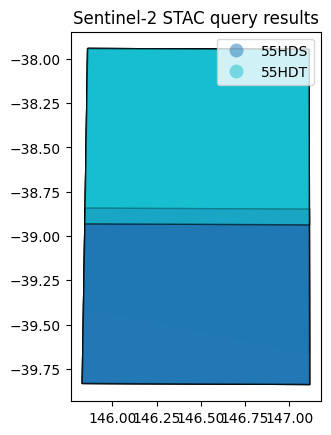

In [8]:
gdf = gpd.GeoDataFrame.from_features(stac_json, f"epsg:{crs}")

# compute granule id from components
gdf["granule"]= (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

fig = gdf.plot("granule",
               edgecolor="black",
               alpha=0.5,
               categorical=True,
               aspect="equal",
               legend=True)

_=fig.set_title("Sentinel-2 STAC query results")

In [9]:

#lazily combine
xx = stac_load(
    items,
    bands = ("red", "green", "blue", "nir", "scl"),
    #crs=f"epsg:{crs}",
    resolution = resolution,
    chunks={}, # use dask
    groupby = "solar_day", #this merges adjacent scenes and de-duplicates overlapping pixels
    bbox = bbox,
    resampling="bilinear"
)

# data is not loaded yet
display(xx)

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 457, x: 514, time: 7)
Coordinates:
  * y            (y) float64 4kB 5.703e+06 5.703e+06 ... 5.699e+06 5.699e+06
  * x            (x) float64 4kB 4.229e+05 4.23e+05 ... 4.281e+05 4.281e+05
    spatial_ref  int32 4B 32755
  * time         (time) datetime64[ns] 56B 2024-04-01T00:17:32.095000 ... 202...
Data variables:
    red          (time, y, x) uint16 3MB dask.array<chunksize=(1, 457, 514), meta=np.ndarray>
    green        (time, y, x) uint16 3MB dask.array<chunksize=(1, 457, 514), meta=np.ndarray>
    blue         (time, y, x) uint16 3MB dask.array<chunksize=(1, 457, 514), meta=np.ndarray>
    nir          (time, y, x) uint16 3MB dask.array<chunksize=(1, 457, 514), meta=np.ndarray>
    scl          (time, y, x) uint8 2MB dask.array<chunksize=(1, 457, 514), meta=np.ndarray>

In [10]:
%%time

#no progress bar showing?
with ProgressBar():
   xx = xx.load()
    

CPU times: user 1.46 s, sys: 320 ms, total: 1.78 s
Wall time: 27.6 s


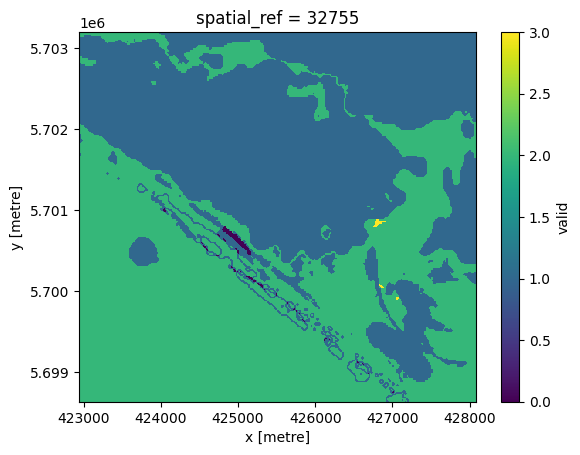

In [11]:
# define a mask for valid pixels (non-cloud)

def is_valid_pixel(data):
    # include only vegetated, not_vegitated, water, and snow
    return ((data > 3) & (data < 7)) | (data==11)

xx['valid'] = is_valid_pixel(xx.scl)
xx.valid.sum("time").plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


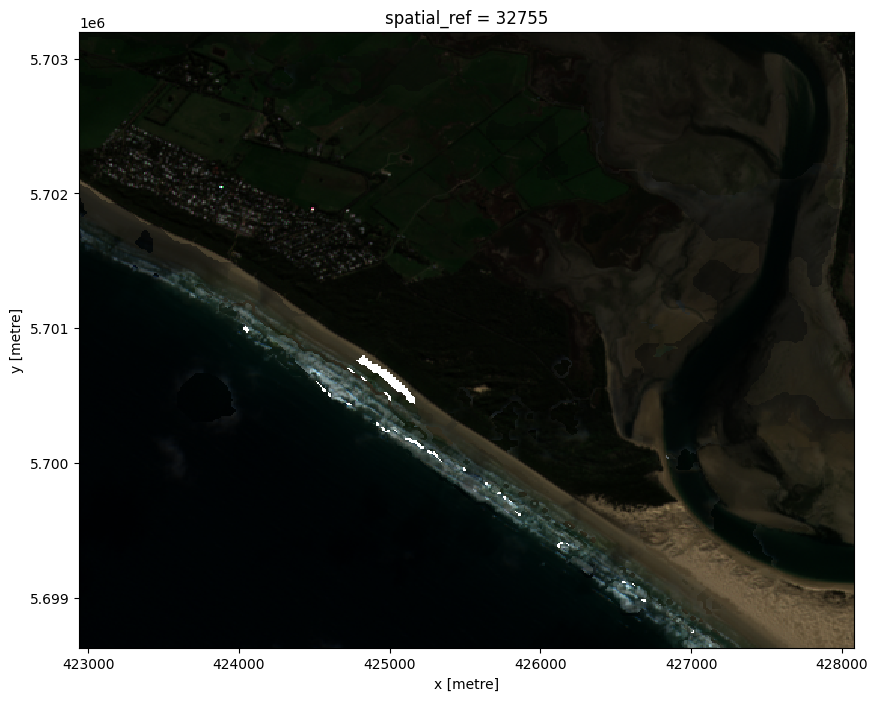

In [12]:
# compute the masked median
rgb_median = (
    xx[['red', 'green', 'blue']]
    .where(xx.valid)
    .to_dataarray(dim="band")
    .transpose(..., "band")
    .median(dim="time")
)
(rgb_median / rgb_median.max() * 2).plot.imshow(rgb="band", figsize=(10, 8))

In [13]:
# band data is in uint16, convert to float32 rough and quick:

xx = xx/10000

xx

<xarray.Dataset> Size: 79MB
Dimensions:      (y: 457, x: 514, time: 7)
Coordinates:
  * y            (y) float64 4kB 5.703e+06 5.703e+06 ... 5.699e+06 5.699e+06
  * x            (x) float64 4kB 4.229e+05 4.23e+05 ... 4.281e+05 4.281e+05
    spatial_ref  int32 4B 32755
  * time         (time) datetime64[ns] 56B 2024-04-01T00:17:32.095000 ... 202...
Data variables:
    red          (time, y, x) float64 13MB 0.2792 0.2776 0.282 ... 0.4232 0.3976
    green        (time, y, x) float64 13MB 0.2956 0.3028 0.2974 ... 0.352 0.3496
    blue         (time, y, x) float64 13MB 0.3168 0.3164 0.314 ... 0.2718 0.2584
    nir          (time, y, x) float64 13MB 0.3884 0.386 0.388 ... 0.4696 0.4428
    scl          (time, y, x) float64 13MB 0.0009 0.0009 ... 0.0005 0.0005
    valid        (time, y, x) float64 13MB 0.0 0.0 0.0 ... 0.0001 0.0001 0.0001

In [14]:
def calc_ndvi(data):
    return (data.nir - data.red) / (data.nir + data.red)


xx['ndvi'] = calc_ndvi(xx)

In [15]:
xx

<xarray.Dataset> Size: 92MB
Dimensions:      (y: 457, x: 514, time: 7)
Coordinates:
  * y            (y) float64 4kB 5.703e+06 5.703e+06 ... 5.699e+06 5.699e+06
  * x            (x) float64 4kB 4.229e+05 4.23e+05 ... 4.281e+05 4.281e+05
    spatial_ref  int32 4B 32755
  * time         (time) datetime64[ns] 56B 2024-04-01T00:17:32.095000 ... 202...
Data variables:
    red          (time, y, x) float64 13MB 0.2792 0.2776 0.282 ... 0.4232 0.3976
    green        (time, y, x) float64 13MB 0.2956 0.3028 0.2974 ... 0.352 0.3496
    blue         (time, y, x) float64 13MB 0.3168 0.3164 0.314 ... 0.2718 0.2584
    nir          (time, y, x) float64 13MB 0.3884 0.386 0.388 ... 0.4696 0.4428
    scl          (time, y, x) float64 13MB 0.0009 0.0009 ... 0.0005 0.0005
    valid        (time, y, x) float64 13MB 0.0 0.0 0.0 ... 0.0001 0.0001 0.0001
    ndvi         (time, y, x) float64 13MB 0.1636 0.1634 ... 0.05197 0.05378

In [29]:
%pip install matplotlib -q
%pip install cartopy -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

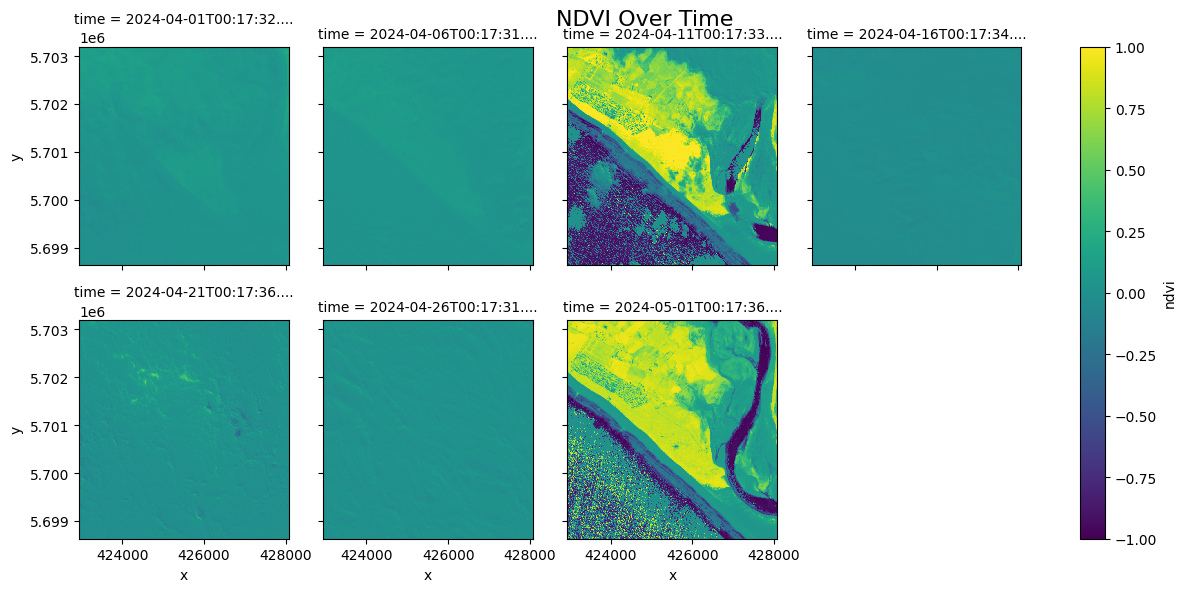

In [38]:
p = xx['ndvi'].plot(x='x', y='y', col='time', col_wrap=4, vmin=-1, vmax=1, cmap='viridis')

# Add overall title and adjust spacing
p.fig.suptitle('NDVI Over Time', fontsize=16)

plt.show()